In [21]:
from mozilla_voice_tts.utils.audio import AudioProcessor
from mozilla_voice_tts.utils.io import load_config
from mozilla_voice_tts.tts.utils.visual import plot_spectrogram
import librosa
import glob
import IPython.display as ipd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import seaborn as sns
from scipy import interpolate
import json
from multiprocessing import Pool
import math

In [2]:
%matplotlib inline

In [72]:
class Mel2MelDataset(Dataset):
    def __init__(self, path, INPUT_SR, TARGET_SR, WINDOW_LENGTH):
        self.INPUT_SR = INPUT_SR
        self.TARGET_SR = TARGET_SR
        self.WINDOW_LENGTH = WINDOW_LENGTH
        self.CONFIG = load_config('config_fr.json')
        self.CONFIG['audio']['sample_rate'] = self.INPUT_SR
        self.AP_INPUT = AudioProcessor(**self.CONFIG['audio'])
        self.CONFIG['audio']['sample_rate'] = self.TARGET_SR
        self.AP_TARGET = AudioProcessor(**self.CONFIG['audio'])
        self.files = glob.glob(path+'/**/*.wav',recursive=True)
        #If you change your dataset, delete cache.json
        if os.path.isfile('./cache.json'):
            with open('./cache.json', "r") as json_file:
                self.pre_repertoir = json.load(json_file)
        else:
            print("> Computing wave files length...")
            self.pre_repertoir = [librosa.get_duration(filename=file) for file in tqdm(self.files)]
            with open('./cache.json', mode="w") as json_file:
                json.dump(self.pre_repertoir, json_file)
        self.repertoir = [int(item / WINDOW_LENGTH) for item in self.pre_repertoir]
        self.length = self.get_len()
        
    def __len__(self):
        return self.length

    def __getitem__(self, id):
        ref = self.get_reference(id)
        print(ref)
        print(librosa.get_duration(filename=self.files[self.repertoir[ref[0]]]))
        input_wav, _ = librosa.load(self.files[ref[0]], offset=self.WINDOW_LENGTH*ref[1], duration=self.WINDOW_LENGTH)
        target_wav = librosa.resample(input_wav, self.INPUT_SR, self.TARGET_SR)
        input = torch.tensor(self.AP_INPUT.melspectrogram(input_wav))
        target = torch.tensor(self.AP_TARGET.melspectrogram(target_wav))
        scale_factor=(target.shape[0]/input.shape[0],target.shape[1]/input.shape[1])
        input = torch.nn.functional.interpolate(input.unsqueeze(0).unsqueeze(0), scale_factor=scale_factor, mode='bilinear').reshape(target.shape)
        return (self.normalize(input), self.normalize(target))
    
    def get_reference(self, id):
        i = 0
        sum = 0
        while True:
            if(sum > id):
                return (i - 1,  id - sum + self.repertoir[i-1])
            else:
                sum += self.repertoir[i]
                i+=1
    
    def get_len(self):
        sum = 0
        for num in self.repertoir:
            sum += num
        return sum
    
    def normalize(self, tensor):
        return tensor / 8 + 0.5
    
    def denormalize(self, tensor):
        return tensor - 0.5 * 8


In [73]:
INPUT_SR = 16000
TARGET_SR = 22050
WINDOW_LENGTH = 1.07412

dataset = Mel2MelDataset('/Users/julian/workspace/ML/mailabs', INPUT_SR, TARGET_SR, WINDOW_LENGTH)

> Setting up Audio Processor...
 | > sample_rate:16000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > stats_path:None
 | > hop_length:256
 | > win_length:1024
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | >

In [74]:
item = dataset.__getitem__(8)

(1, 6)
6.0598125


In [71]:
print(dataset.repertoir[1])

8


In [64]:
int(6.0598125 / WINDOW_LENGTH)

5

torch.Size([80, 128])

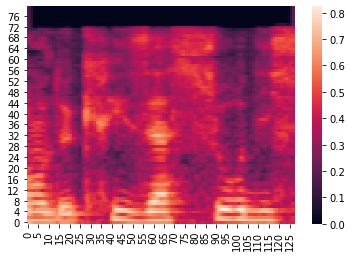

In [6]:
sns.heatmap(item[0]).invert_yaxis()
item[1].shape

torch.Size([80, 128])

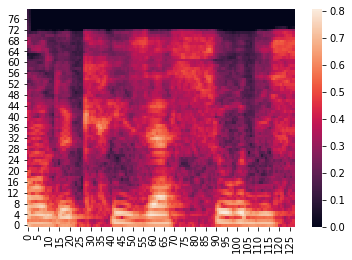

In [7]:
sns.heatmap(item[1]).invert_yaxis()
item[1].shape

In [75]:
for i in tqdm(range(dataset.get_len())):
    dataset.__getitem__(i)

0%|          | 1/155421 [00:00<4:39:59,  9.25it/s](0, 0)
4.9498125
(0, 1)
4.9498125
(1, 0)
  0%|          | 3/155421 [00:00<4:23:17,  9.84it/s]6.0598125
(1, 1)
6.0598125
(1, 2)
6.0598125
  0%|          | 7/155421 [00:00<3:56:20, 10.96it/s](1, 3)
6.0598125
(1, 4)
6.0598125
(1, 5)
6.0598125
  0%|          | 9/155421 [00:00<3:44:22, 11.54it/s](1, 6)
6.0598125
(1, 7)
6.0598125
(2, 0)
8.6998125
  0%|          | 13/155421 [00:01<3:33:31, 12.13it/s](2, 1)
8.6998125
(2, 2)
8.6998125
(2, 3)
8.6998125
  0%|          | 15/155421 [00:01<3:32:14, 12.20it/s](3, 0)
4.5398125
(3, 1)
4.5398125
(3, 2)
4.5398125
  0%|          | 19/155421 [00:01<3:25:05, 12.63it/s](3, 3)
4.5398125
(3, 4)
4.5398125
(4, 0)
6.0598125
  0%|          | 21/155421 [00:01<3:20:38, 12.91it/s](4, 1)
6.0598125
(4, 2)
6.0598125
(4, 3)
6.0598125
  0%|          | 25/155421 [00:01<3:19:05, 13.01it/s](4, 4)
6.0598125
(4, 5)
6.0598125
(4, 6)
6.0598125
  0%|          | 27/155421 [00:02<3:20:59, 12.89it/s](4, 7)
6.0598125
(5, 0)
8.6998125


KeyboardInterrupt: 